# Final List of oncRNAs
Here we also visualized loci to break up and narrow down the loci we see.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json as js
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
oncRNAs = pd.read_csv("results/thresholded_oncRNAs.bed", header=None, sep="\t")
oncRNAs["length"] = oncRNAs[2] - oncRNAs[1]
oncRNAs

,0,1,2,3,4,5,length
0,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,22
1,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,21
2,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,19
3,chr12,71664021,71664096,chr12:71664021-71664096:+,.,+,75
4,chr16,48178002,48178029,chr16:48178002-48178029:-,.,-,27
...,...,...,...,...,...,...,...
64,chr8,123042578,123042655,chr8:123042578-123042655:+,.,+,77
65,chr20,9357008,9357103,chr20:9357008-9357103:+,.,+,95
66,chrX,125095170,125095188,chrX:125095170-125095188:+,.,+,18
67,chr9,14613887,14613949,chr9:14613887-14613949:-,.,-,62


(array([17., 15.,  8.,  7.,  3.,  3.,  5.,  5.,  3.,  3.]),
 array([ 18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99., 108.]),
 <BarContainer object of 10 artists>)

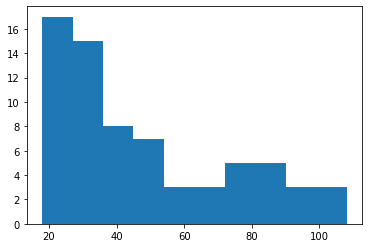

In [3]:
plt.hist(oncRNAs["length"])

# Visualization

In [4]:
with open('data/counts/cell_lines_cpm_map.json', 'r') as f:
    cell_lines_cpm_map = js.load(f)
    f.close()
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()

In [5]:
#Create df for heatmap visualization
loci_exp = {}
for locus in oncRNAs[3]:
    loci_exp[locus] = {}
    for cell_line, loci_dict in sample_loci.items():
        if locus in loci_dict:
            loci_exp[locus][cell_line] = loci_dict[locus] * cell_lines_cpm_map[cell_line] #Transform raw count to cpm. Note we use the cpm_map from non ex-filtered dataset to capture whole count.
        else:
            loci_exp[locus][cell_line] = 0

In [6]:
loci_exp_df = pd.DataFrame.from_dict(loci_exp, orient="index")

In [7]:
subtype_map = {"MDA453":"HER2+", "SKBR-3":"HER2+", 
              "HUMEC":"Normal", "ZR75-1":"Luminal", "HCC38": "TNBC",
              "CN34":"TNBC", "MCF7": "Luminal", "MDA231":"TNBC", 
              "LM2":"Met", "LM1a":"Met"}

In [8]:
colData = pd.DataFrame(loci_exp_df.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Cell Line"] = colData["Sample"].apply(lambda x: x.split("_")[0]) #From sample name, get cell line information
colData["Subtype"] = colData["Cell Line"].apply(lambda x: subtype_map[x]) #Base on cell line, map to subtype category
colData = colData.sort_values("Cell Line").sort_values("Subtype") #First sort by cell line then by subtype
colData = pd.concat([colData[colData["Subtype"] == "Normal"], colData[colData["Subtype"] != "Normal"]]).copy()
colData = colData.set_index("Subtype", drop=False)

colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [9]:
#Max norm
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm

In [10]:
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

<Figure size 1440x1440 with 0 Axes>

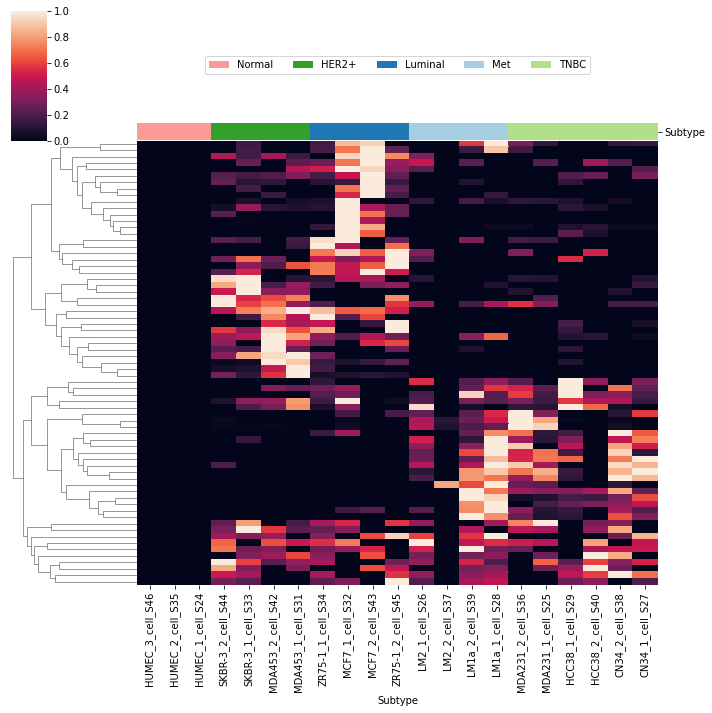

In [11]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, col_colors=col_colors,yticklabels=False, xticklabels=colData["Sample"], method="average", rasterized=True)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_oncRNA_loci_heatmap.pdf")

# Visualize

In [12]:
pos_density = pd.read_csv("data/IC/all_samples_pos_bg.txt", header=None, sep="\t")
neg_density = pd.read_csv("data/IC/all_samples_neg_bg.txt", header=None, sep="\t")

chr2:111153783-111153820:+
111153783
111153820


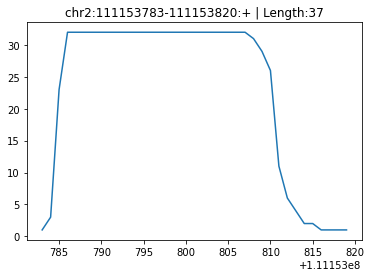

In [223]:
oncRNA = oncRNAs.iloc[68]
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]] #Match reference
density = density[(density[1] >= oncRNA[1]) & (density[2] <= oncRNA[2])] #Match oncRNA loci
coord = []
coverage = []
first = density.iloc[0][1] #Start of loci
for i in range(density.shape[0]):
    row = density.iloc[i]
    start = row[1]
    end = row[2]
    count = row[3]
    assert first == start #Ensure continuity
    while start < end:
        coord.append(start)
        coverage.append(count)
        start += 1
        first += 1
    
density_df = pd.DataFrame({"Coord":coord, "Coverage":coverage})
plt.plot(density_df["Coord"], density_df["Coverage"])
plt.title(oncRNA[3] + f" | Length:{oncRNA[2] - oncRNA[1]}")
print(oncRNA[3])
print(oncRNA[1])
print(oncRNA[2])

In [218]:
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]] #Match reference

In [219]:
density[density[1] >= oncRNA[1]-20].sort_values(1).head(10)

,0,1,2,3
217557,chr2,111153783,111153784,1
217558,chr2,111153784,111153785,3
217559,chr2,111153785,111153786,23
217560,chr2,111153786,111153808,32
217561,chr2,111153808,111153809,31
217562,chr2,111153809,111153810,29
217563,chr2,111153810,111153811,26
217564,chr2,111153811,111153812,11
217565,chr2,111153812,111153813,6
217566,chr2,111153813,111153814,4


In [220]:
density[density[1] >= oncRNA[1]].sort_values(1).head(15)

,0,1,2,3
217557,chr2,111153783,111153784,1
217558,chr2,111153784,111153785,3
217559,chr2,111153785,111153786,23
217560,chr2,111153786,111153808,32
217561,chr2,111153808,111153809,31
217562,chr2,111153809,111153810,29
217563,chr2,111153810,111153811,26
217564,chr2,111153811,111153812,11
217565,chr2,111153812,111153813,6
217566,chr2,111153813,111153814,4


In [319]:
split_loci = {"chr12:71664021-71664096:+": ["chr12:71664059-71664094:+"],
             "chrX:127317160-127317210:+" : ["chrX:127317160-127317185:+", "chrX:127317185-127317210:+"],
             "chr3:172821369-172821477:+":["chr3:172821431-172821476:+"],
             "chr6:52264623-52264696:-": ["chr6:52264623-52264653:-"],
             "chr9:113514723-113514767:+":["chr9:113514723-113514759:+"],
             "chr1:156701076-156701120:-":["chr1:156701092-156701120:-"],
             "chr19:17337553-17337641:+":["chr19:17337580-17337620:+"],
             "chr19:39473382-39473416:+":["chr19:39473388-39473416:+"],
             "chr2:121727242-121727324:-":["chr2:121727244-121727276:-"],
             "chr2:237545697-237545743:+":["chr2:237545716-237545743:+"],
             "chr16:15576880-15576933:-":["chr16:15576883-15576904:-", "chr16:15576902-15576933:-"], 
             "chr16:21526902-21526948:-":["chr16:21526902-21526946:-"],
             "chr16:28845601-28845647:+":["chr16:28845603-28845643:+"],
             "chr20:50752735-50752776:+":["chr20:50752738-50752776:+"],
             "chr3:179399575-179399631:-":["chr3:179399592-179399630:-"], 
             "chr7:66811360-66811433:+":["chr7:66811360-66811398:+"],
             "chr7:30082319-30082414:+":["chr7:30082359-30082400:+"],
             "chr7:36389850-36389931:+":["chr7:36389875-36389910:+"],
             "chr7:92605706-92605776:-":["chr7:92605747-92605776:-"],
             "chr10:59791859-59791902:-":["chr10:59791871-59791902:-"],
             "chr17:68101412-68101494:-":["chr17:68101451-68101490:-"],
             "chr17:39716415-39716514:+":["chr17:39716433-39716478:+"],
             "chr4:55336774-55336832:-":["chr4:55336788-55336831:-"],
             "chr16:85015943-85016011:-":["chr16:85015956-85015994:-"],
             "chr20:36916711-36916760:-":["chr20:36916726-36916760:-"],
             "chr2:102716142-102716211:-":["chr2:102716145-102716188:-"],
             "chr20:62327667-62327746:-":["chr20:62327667-62327693:-"],
             "chr7:139299611-139299712:+":["chr7:139299644-139299679:+"],
             "chr8:103430637-103430690:+":["chr8:103430644-103430682:+"],
             "chr3:42224520-42224615:+":["chr3:42224520-42224551:+"],
             "chr1:149558545-149558588:-":["chr1:149558545-149558569:-"],
             "chr20:56639188-56639276:+":["chr20:56639206-56639251:+"],
             "chr8:123042578-123042655:+":["chr8:123042582-123042615:+"],
             "chr20:9357008-9357103:+":["chr20:9357016-9357046:+","chr20:9357046-9357077:+", "chr20:9357065-9357096:+"],
             "chr9:14613887-14613949:-":["chr9:14613907-14613937:-"],
             "chr2:111153783-111153820:+":["chr2:111153783-111153816:+"]}


In [320]:
final_list = []
for rna in oncRNAs[3]:
    if rna in split_loci:
        final_list.extend(split_loci[rna])
    else:
        final_list.append(rna)
len(final_list)

73

In [321]:
with open("results/final_oncRNA_list.bed", "w") as out:
    for locus in final_list:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")          

# Test to Make Sure No Errors

With `-v` we test to make sure all of the rnas in the `final_oncRNA_list.bed` file maps to one of the oncRNA annotations. If no errors nothing should be reported.

In [322]:
%%bash
bedtools intersect -v -s -a results/final_oncRNA_list.bed -b results/thresholded_oncRNAs.bed

Great.

Here we do the opposite. To make sure all the oncRNAs in the `15%_fdr_tcga.bed` are accounted for.

In [323]:
%%bash
bedtools intersect -v -s -a results/thresholded_oncRNAs.bed -b results/final_oncRNA_list.bed

Great.

In [324]:
%%bash
bedtools intersect -wao -s -a results/thresholded_oncRNAs.bed -b results/final_oncRNA_list.bed > results/map_oncRNAs.bed

# Final Check of Lengths

In [325]:
lengths = []
for rna in final_list:
    start = int(rna.split(":")[1].split("-")[0])
    end = int(rna.split(":")[1].split("-")[1])
    lengths.append(end-start)

(array([ 2.,  9., 11.,  7., 17.,  5.,  6.,  7.,  3.,  6.]),
 array([18. , 20.7, 23.4, 26.1, 28.8, 31.5, 34.2, 36.9, 39.6, 42.3, 45. ]),
 <BarContainer object of 10 artists>)

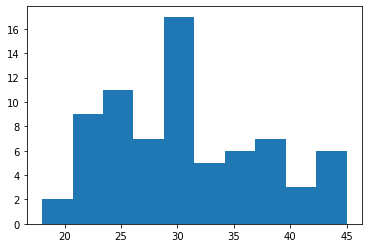

In [326]:
plt.hist(lengths)

# Final Check of Loci

In [327]:
final_check = pd.read_csv("results/map_oncRNAs.bed", sep="\t", header=None)
final_check.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,22
1,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,21
2,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,19
3,chr12,71664021,71664096,chr12:71664021-71664096:+,.,+,chr12,71664059,71664094,chr12:71664059-71664094:+,.,+,35
4,chr16,48178002,48178029,chr16:48178002-48178029:-,.,-,chr16,48178002,48178029,chr16:48178002-48178029:-,.,-,27


In [404]:
j = 0

0
chr7:13735449-13735471:-
chr7:13735449-13735471:-


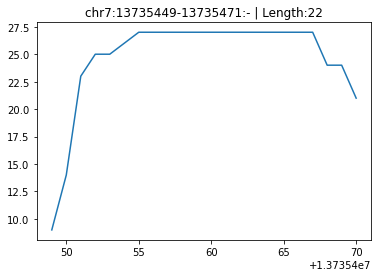

In [405]:
oncRNA = final_check.iloc[j]
loci_start = oncRNA[7]
loci_end = oncRNA[8]
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]]
density = density[(density[1] >= oncRNA[1]) & (density[2] <= oncRNA[2])]
coord = []
coverage = []
first = density.iloc[0][1]
for i in range(density.shape[0]):
    row = density.iloc[i]
    start = row[1]
    end = row[2]
    count = row[3]
    while first < start: #ensure continuity
        coord.append(first)
        coverage.append(0)
        first += 1
    while start < end:
        coord.append(start)
        coverage.append(count)
        start += 1
        first += 1
        
density_df = pd.DataFrame({"Coord":coord[loci_start-oncRNA[1]:loci_end - oncRNA[1]+1], "Coverage":coverage[loci_start-oncRNA[1]:loci_end - oncRNA[1]+1]})
plt.plot(density_df["Coord"], density_df["Coverage"])
new_locus = f"{oncRNA[0]}:{loci_start}-{loci_end}:{oncRNA[5]}"
plt.title(new_locus + f" | Length:{loci_end - loci_start}")
print(j)
print(new_locus)
print(oncRNA[3])
j += 1

## Convert to fastq sequences file

In [406]:
%%bash
echo "bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s";
bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s;

bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s


In [407]:
with open('results/final_oncRNA.txt', "w") as out:
    with open("results/final_oncRNA.fa", "r") as read:
        for line in read:
            if ">" not in line:
                out.write(line)

# Annotations
Make sure none of these finalized oncRNAs map to a known smRNAs. Below code should return 0 results.

In [408]:
%%bash
bedtools intersect -wo -s -a results/final_oncRNA_list.bed -b /rumi/shams/jwang/genomes/hg38/dashr.v2.smRNA.hg38.bed

# Done